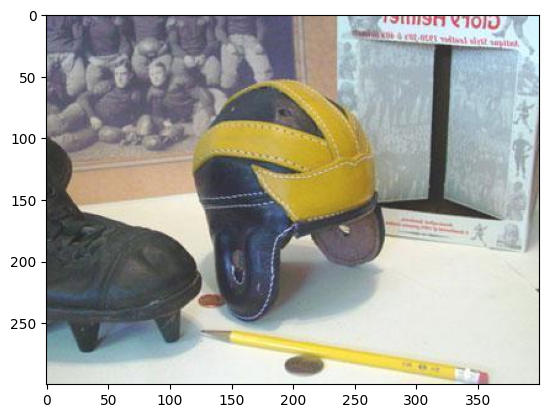

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the path to the dataset (adjust based on your system)
dataset_path = os.path.expanduser(r'/kaggle/input/caltech256/256_ObjectCategories')

# List the categories (folders inside the dataset folder)
categories = os.listdir(dataset_path)

# Example: Load and display the first image from a category
category = categories[0]
image_path = os.path.join(dataset_path, category, os.listdir(os.path.join(dataset_path, category))[0])

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()


In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=r'/kaggle/input/caltech256/256_ObjectCategories',transform=transform)

# Calculate sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset1, test_dataset1 = random_split(dataset, [train_size, test_size])
test_dataloader=DataLoader(test_dataset1,batch_size=256,shuffle=True)
# Define the DataLoader
data_loader = DataLoader(train_dataset1, batch_size=256, shuffle=True)


In [4]:
from torch.utils.data import Dataset

class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


In [5]:
from tqdm import tqdm
import numpy as np

# Define a transform (e.g., resizing, normalization)
import torch
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)


'''
for calulating mean and std

image_mean = 0.0
image_std = 0.0
nb_samples = 0

for images, _ in tqdm(data_loader):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)  # [B, C, H*W]
    image_mean += images.mean(2).sum(0)
    image_std += images.std(2).sum(0)
    nb_samples += batch_samples

image_mean /= nb_samples
image_std /= nb_samples
'''

train_transforms = Compose([
    #RandomResizedCrop(size=(224, 224), antialias=True),
    #RandomHorizontalFlip(p=0.5),
    Resize((224, 224)),
    ToTensor(), #Adding ToTensor to the Compose
    Normalize(mean=[0.5524, 0.5334, 0.5045], std=[0.5524, 0.5334, 0.5045]),
])
test_transforms=Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.5524, 0.5334, 0.5045], std=[0.5524, 0.5334, 0.5045])
])

# Assign separate transforms
train_dataset = SubsetWithTransform(train_dataset1, transform=train_transforms)
test_dataset=SubsetWithTransform(test_dataset1,transform=test_transforms)
train_dataloader=DataLoader(train_dataset, batch_size=256, shuffle=True,num_workers=4)
test_dataloader=DataLoader(test_dataset,batch_size=256,shuffle=True,num_workers=4)
# Load the dataset

In [7]:
#!pip install timm torchvision --quiet
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


In [64]:
import timm
import torch.nn as nn

model = timm.create_model('vit_small_patch16_224', pretrained=True)

model.head = nn.Linear(model.head.in_features, 257)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the head (final classification layer)
for param in model.head.parameters():
    param.requires_grad = True
model.to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [70]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm  # Import tqdm for progress bar
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(1):  # Adjust as needed
    model.train()
    total_loss = 0

    # Wrap the dataloader with tqdm for a progress bar
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()



    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_dataloader):.4f}")



/tmp/ipykernel_31/2252706937.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_31/2252706937.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]

Epoch 1, Loss: 1.1089


In [74]:
total_loss

106.45647346973419

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [71]:
from tqdm import tqdm
import numpy as np
import torch
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation during inference
    for images, labels in tqdm(test_dataloader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Evaluating: 100%|██████████| 24/24 [00:15<00:00,  1.55it/s]


In [72]:
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

Top-1 Accuracy: 0.8502
Precision: 0.8538
Recall: 0.8502
F1-score: 0.8457


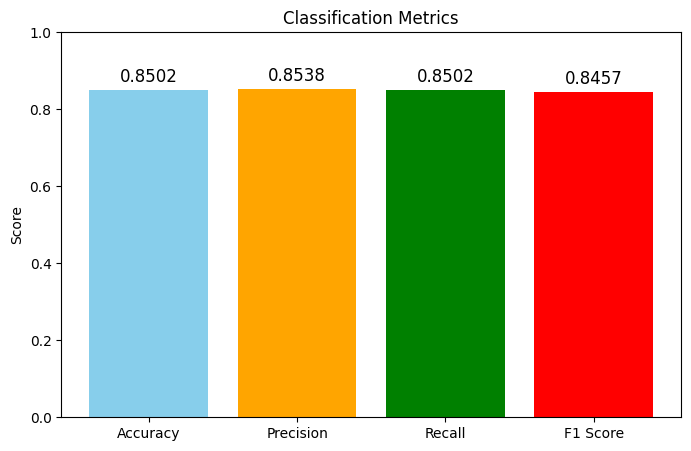

In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
print(f"Top-1 Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
metrics = [accuracy, precision, recall, f1]
#metrics = [0.85, 0.90, 0.78, 0.92]  # Example metrics (e.g., accuracy, precision, recall, F1)
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, metrics, color=['skyblue', 'orange', 'green', 'red'])

# Adding text on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,  # Place text slightly above the bar
             f'{yval:.4f}', ha='center', va='bottom', fontsize=12)

plt.ylim(0, 1)  # Set y-axis limits for better spacing above the bars
plt.ylabel('Score')
plt.title('Classification Metrics')
plt.show()

In [14]:
import torch
import timm
import torch.nn as nn

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model
model1 = timm.create_model('coatnet_1_rw_224.sw_in1k', pretrained=True)

# Get the number of input features of the classifier
in_features = model1.get_classifier().in_features

# Define the number of target classes
num_classes = 257

# Replace the classifier head
model1.reset_classifier(num_classes=num_classes)

# Freeze all layers
for param in model1.parameters():
    param.requires_grad = False

# Unfreeze the classifier head
for param in model1.get_classifier().parameters():
    param.requires_grad = True

# Move model to device
model1.to(device)


MaxxVit(
  (stem): Stem(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (stages): Sequential(
    (0): MaxxVitStage(
      (blocks): Sequential(
        (0): MbConvBlock(
          (shortcut): Downsample2d(
            (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
            (expand): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (pre_norm): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (down): Identity()
          (conv1_1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (no

In [27]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm  # Import tqdm for progress bar
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model1.parameters(), lr=1e-4)

for epoch in range(2):  # Adjust as needed
    model1.train()
    total_loss = 0

    # Wrap the dataloader with tqdm for a progress bar
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model1(images)

        with autocast():
            outputs = model1(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()



    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_dataloader):.4f}")



/tmp/ipykernel_31/2674499231.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_31/2674499231.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1: 100%|██████████| 96/96 [03:42<00:00,  2.31s/it]


Epoch 1, Loss: 0.4086


Epoch 2: 100%|██████████| 96/96 [03:42<00:00,  2.31s/it]

Epoch 2, Loss: 0.3842


In [1]:
print(2)

2


In [28]:
total_loss

36.88244515657425

In [29]:
from tqdm import tqdm
import numpy as np
import torch
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation during inference
    for images, labels in tqdm(test_dataloader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Evaluating: 100%|██████████| 24/24 [00:31<00:00,  1.31s/it]


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

Top-1 Accuracy: 0.8623
Precision: 0.8666
Recall: 0.8623
F1-score: 0.8605


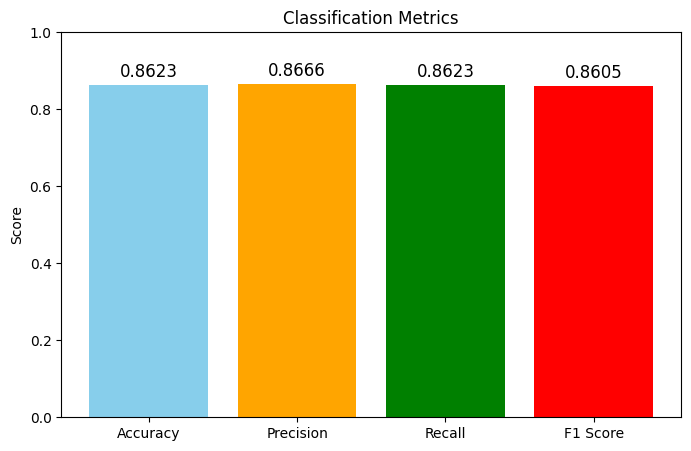

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
print(f"Top-1 Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
metrics = [accuracy, precision, recall, f1]
#metrics = [0.85, 0.90, 0.78, 0.92]  # Example metrics (e.g., accuracy, precision, recall, F1)
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, metrics, color=['skyblue', 'orange', 'green', 'red'])

# Adding text on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,  # Place text slightly above the bar
             f'{yval:.4f}', ha='center', va='bottom', fontsize=12)

plt.ylim(0, 1)  # Set y-axis limits for better spacing above the bars
plt.ylabel('Score')
plt.title('Classification Metrics')
plt.show()

In [57]:
import timm
import torch.nn as nn

model2 = timm.create_model('vit_base_patch16_224_in21k', pretrained=True)

model2.head = nn.Linear(model2.head.in_features, 257)
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the head (final classification layer)
for param in model2.head.parameters():
    param.requires_grad = True
model2.to(device)


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [58]:
new_transforms = Compose([
    #RandomResizedCrop(size=(224, 224), antialias=True),
    #RandomHorizontalFlip(p=0.5),
    Resize((224, 224)),
    ToTensor(), #Adding ToTensor to the Compose
    Normalize(mean=[0.5524, 0.5334, 0.5045], std=[0.5524, 0.5334, 0.5045]),
])


train_dataset = SubsetWithTransform(train_dataset1, transform=new_transforms)
test_dataset=SubsetWithTransform(test_dataset1,transform=new_transforms)
train_dataloader=DataLoader(train_dataset, batch_size=256, shuffle=True,num_workers=4)
test_dataloader=DataLoader(test_dataset,batch_size=256,shuffle=True,num_workers=4)

In [59]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm  # Import tqdm for progress bar
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model2.parameters(), lr=1e-4)

for epoch in range(10):  # Adjust as needed
    model2.train()
    total_loss = 0

    # Wrap the dataloader with tqdm for a progress bar
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model2(images)

        with autocast():
            outputs = model2(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()



    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_dataloader):.4f}")



/tmp/ipykernel_31/886744350.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_31/886744350.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1: 100%|██████████| 96/96 [04:44<00:00,  2.96s/it]


Epoch 1, Loss: 4.6983


Epoch 2: 100%|██████████| 96/96 [04:44<00:00,  2.96s/it]


Epoch 2, Loss: 1.7997


Epoch 3: 100%|██████████| 96/96 [04:44<00:00,  2.96s/it]


Epoch 3, Loss: 0.8394


Epoch 4: 100%|██████████| 96/96 [04:44<00:00,  2.96s/it]


Epoch 4, Loss: 0.5253


Epoch 5: 100%|██████████| 96/96 [04:44<00:00,  2.96s/it]


Epoch 5, Loss: 0.3793


Epoch 6: 100%|██████████| 96/96 [04:45<00:00,  2.97s/it]


Epoch 6, Loss: 0.2925


Epoch 7: 100%|██████████| 96/96 [04:49<00:00,  3.01s/it]


Epoch 7, Loss: 0.2338


Epoch 8: 100%|██████████| 96/96 [04:44<00:00,  2.96s/it]


Epoch 8, Loss: 0.1909


Epoch 9: 100%|██████████| 96/96 [04:44<00:00,  2.96s/it]


Epoch 9, Loss: 0.1584


Epoch 10: 100%|██████████| 96/96 [04:44<00:00,  2.96s/it]

Epoch 10, Loss: 0.1319


In [60]:
from tqdm import tqdm
import numpy as np
import torch
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation during inference
    for images, labels in tqdm(test_dataloader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Evaluating: 100%|██████████| 24/24 [00:39<00:00,  1.66s/it]


In [61]:
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

In [62]:
print(f"Top-1 Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Top-1 Accuracy: 0.9356
Precision: 0.9395
Recall: 0.9356
F1-score: 0.9359


Top-1 Accuracy: 0.9356
Precision: 0.9395
Recall: 0.9356
F1-score: 0.9359


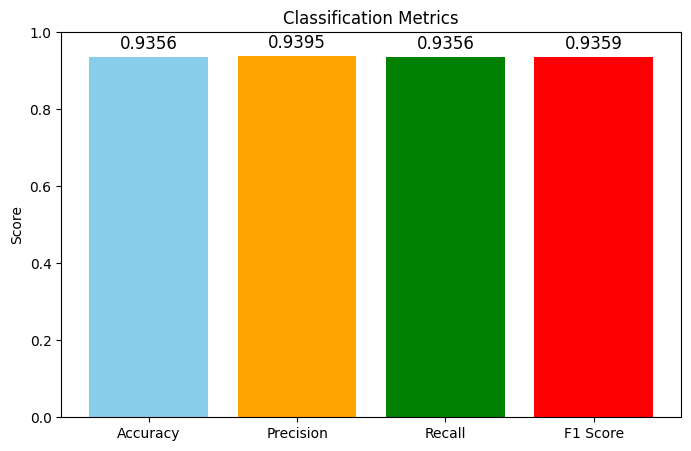

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
print(f"Top-1 Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
metrics = [accuracy, precision, recall, f1]
#metrics = [0.85, 0.90, 0.78, 0.92]  # Example metrics (e.g., accuracy, precision, recall, F1)
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, metrics, color=['skyblue', 'orange', 'green', 'red'])

# Adding text on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,  # Place text slightly above the bar
             f'{yval:.4f}', ha='center', va='bottom', fontsize=12)

plt.ylim(0, 1)  # Set y-axis limits for better spacing above the bars
plt.ylabel('Score')
plt.title('Classification Metrics')
plt.show()

In [8]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained AlexNet from torchvision
model5 = models.alexnet(pretrained=True)

# Freeze all parameters
for param in model5.parameters():
    param.requires_grad = True

# Replace the classifier with a single linear layer (e.g., for 10 classes)
in_features = model5.classifier[6].in_features
model5.classifier[6] = nn.Linear(in_features, 257)

# Unfreeze the classifier layer only
for param in model5.classifier[6].parameters():
    param.requires_grad = True
model5.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model5.parameters(), lr=1e-4)

for epoch in range(15):
    model5.train()
    total_loss = 0.0

    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():  # Mixed precision context
            outputs = model5(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


/tmp/ipykernel_31/3897586823.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_31/3897586823.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision context
Epoch 1: 100%|██████████| 96/96 [01:27<00:00,  1.09it/s]


Epoch 1, Loss: 2.7546


Epoch 2: 100%|██████████| 96/96 [00:49<00:00,  1.95it/s]


Epoch 2, Loss: 1.2549


Epoch 3: 100%|██████████| 96/96 [00:48<00:00,  1.98it/s]


Epoch 3, Loss: 0.8024


Epoch 4: 100%|██████████| 96/96 [00:48<00:00,  1.99it/s]


Epoch 4, Loss: 0.5053


Epoch 5: 100%|██████████| 96/96 [00:47<00:00,  2.01it/s]


Epoch 5, Loss: 0.3080


Epoch 6: 100%|██████████| 96/96 [00:48<00:00,  1.98it/s]


Epoch 6, Loss: 0.2067


Epoch 7: 100%|██████████| 96/96 [00:49<00:00,  1.96it/s]


Epoch 7, Loss: 0.1396


Epoch 8: 100%|██████████| 96/96 [00:48<00:00,  1.99it/s]


Epoch 8, Loss: 0.1161


Epoch 9: 100%|██████████| 96/96 [00:48<00:00,  1.99it/s]


Epoch 9, Loss: 0.0943


Epoch 10: 100%|██████████| 96/96 [00:48<00:00,  2.00it/s]


Epoch 10, Loss: 0.0741


Epoch 11: 100%|██████████| 96/96 [00:47<00:00,  2.01it/s]


Epoch 11, Loss: 0.0638


Epoch 12: 100%|██████████| 96/96 [01:38<00:00,  1.03s/it]


Epoch 12, Loss: 0.0618


Epoch 13: 100%|██████████| 96/96 [02:13<00:00,  1.39s/it]


Epoch 13, Loss: 0.0550


Epoch 14: 100%|██████████| 96/96 [00:49<00:00,  1.95it/s]


Epoch 14, Loss: 0.0496


Epoch 15: 100%|██████████| 96/96 [00:49<00:00,  1.95it/s]

Epoch 15, Loss: 0.0483


In [11]:
from tqdm import tqdm
import numpy as np
import torch
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation during inference
    for images, labels in tqdm(test_dataloader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model5(images)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Evaluating: 100%|██████████| 24/24 [00:34<00:00,  1.44s/it]


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

In [14]:
print(f"Top-1 Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Top-1 Accuracy: 0.6460
Precision: 0.6707
Recall: 0.6460
F1-score: 0.6444


Top-1 Accuracy: 0.6460
Precision: 0.6707
Recall: 0.6460
F1-score: 0.6444


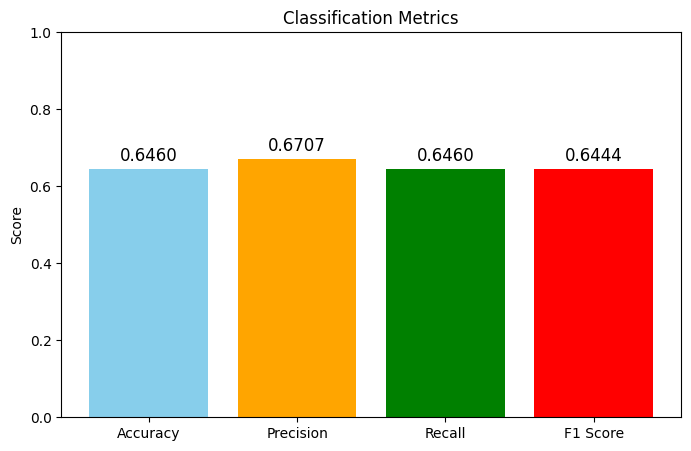

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
print(f"Top-1 Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
metrics = [accuracy, precision, recall, f1]
#metrics = [0.85, 0.90, 0.78, 0.92]  # Example metrics (e.g., accuracy, precision, recall, F1)
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, metrics, color=['skyblue', 'orange', 'green', 'red'])

# Adding text on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,  # Place text slightly above the bar
             f'{yval:.4f}', ha='center', va='bottom', fontsize=12)

plt.ylim(0, 1)  # Set y-axis limits for better spacing above the bars
plt.ylabel('Score')
plt.title('Classification Metrics')
plt.show()

In [1]:
import nbformat

def convert_kaggle_to_jupyter(input_file, output_file):
    nb = nbformat.read(input_file, as_version=nbformat.NO_CONVERT)
    if "widgets" in nb.metadata:
        del nb.metadata["widgets"]  # Remove broken widget state
    nbformat.write(nb, output_file)
    print(f"Converted and saved as: {output_file}")

# Example usage
convert_kaggle_to_jupyter("course_project(2).ipynb", "jupyter_notebook.ipynb")


FileNotFoundError: [Errno 2] No such file or directory: 'course_project(2).ipynb'